In [200]:
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline
import numpy as np

import torch
import torch.nn as nn
from skimage import io
import math

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


In [335]:

IMG_X, IMG_Y = 200,200
# length and width of blocks (fixed for now)
block_l, block_w = 25, 25
num_images = 50

# img_list = []
true_coords = []


# Calc rectangle vertices. makeRectangle() credit Sparkler, stackoverflow, feb 17
def makeRectangle(l, w, theta, offset=(0, 0)):
    c, s = math.cos(theta), math.sin(theta)
    rectCoords = [(l/2.0, w/2.0), (l/2.0, -w/2.0), (-l/2.0, -w/2.0), (-l/2.0, w/2.0)]
    return [(c*x-s*y+offset[0], s*x+c*y+offset[1]) for (x, y) in rectCoords]


# ---- Make depth images ---
for i in range(num_images):
    #orient = 0 # degrees
    img = Image.new('RGB', (IMG_X, IMG_Y), 'black')

    # block_l and _w offset so blocks don't run off edge of image
    rand_x = int(np.random.rand() * (IMG_X-block_l))
    rand_y = int(np.random.rand() * (IMG_Y-block_w))
    orient = int(np.random.rand() * 360)

    true_coords.append(np.array((rand_x, rand_y, orient)))

    rect_vertices = makeRectangle(block_l, block_w, orient, offset=(rand_x,
                                                                    rand_y))
    
    idraw = ImageDraw.Draw(img)
    idraw.polygon(rect_vertices, fill='white')

    # use a truetype font
    #font = ImageFont.truetype("DejavuSans.ttf", 15)
    #font = ImageFont.truetype("Arial.ttf",14)
    #idraw.text((10, 25), '('+ str(rand_x) + ', ' + str(rand_y) +')')


    img.save('./data/rect'+str(i)+'.png')


    
class RectDepthImgsDataset(Dataset):
    """Artificially generated depth images dataset"""

    def __init__(self, img_dir, coords, transform=None):
        """
        """
        self.img_dir = img_dir
        self.true_coords = coords
        self.transform = transform

    def __len__(self):
        return len(self.true_coords)

    def __getitem__(self, idx):
        # image = self.images[idx]
        image = io.imread(self.img_dir + '/rect'+str(idx)+'.png')
        image = torch.FloatTensor(image).permute(2, 0, 1) #PIL and torch expect difft orders
        coords = torch.FloatTensor(true_coords[idx])

        if self.transform:
            image = self.transform(image)

        # sample = {'image': image, 'grasp': str(coords[0]) + str(coords[1])}
        sample = {'image': image, 'grasp': coords}
        sample = image, coords

        return sample

In [387]:
# Hyper parameters

num_epochs = 100 
num_classes = 3 # predicting x,y,orientation
batch_size = 15 
learning_rate = 0.001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("CUDA available? device: ", device)

# Dataset is depth images of rectangular blocks
train_dataset = RectDepthImgsDataset(img_dir='./data', coords=true_coords)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                          shuffle=True)

const = 16*47*47
#const = 16*97*72


# 300x300
#torch.Size([4, 300, 300, 3])
#torch.Size([4, 3, 300, 300])
#torch.Size([4, 6, 148, 148])
#torch.Size([4, 16, 72, 72])


# 200x200
#const = 16*47*47*4
#torch.Size([4, 200, 200, 3])
#torch.Size([4, 3, 200, 200])
#torch.Size([4, 6, 98, 98])
#torch.Size([4, 16, 47, 47])

# = 200-4 / 2
# where 4 = 5x5 (conv) -1 = area of image after conv without padding = 200->98
# = 98-4 / 2
# where 4 = 5x5 (conv) -1 = area of image after conv without padding = 98->47
# output is 47x47 image, with 16 output channels


# 400x300
#torch.Size([4, 300, 400, 3])
#torch.Size([4, 3, 400, 300])
#torch.Size([4, 6, 198, 148])
#torch.Size([4, 16, 97, 72])


class Net(nn.Module):  # CIFAR is 32x32x3, MNIST is 28x28x1)
    def __init__(self, IMG_X, IMG_Y):
        super(Net, self).__init__()
        self._imgx = IMG_X
        self._imgy = IMG_Y
        _pool = 2
        _stride = 5
        _outputlayers = 16
        
        def _calc(val):
            layer_size = (val- (_stride-1)) / _pool
            return layer_size 
        
        #print(self._imgx)
        self._const = _calc(_calc(self._imgx))
        self._const *= _calc(_calc(self._imgy))
        self._const *= _outputlayers 
        #print(self._const)
        self._const = int(self._const)
        
        self.conv1 = nn.Conv2d(3, 6, _stride).to(device)
        self.pool = nn.MaxPool2d(_pool, _pool).to(device)
        self.conv2 = nn.Conv2d(6, _outputlayers, _stride).to(device)
        self.fc1 = nn.Linear(self._const, 120).to(device)
        self.fc2 = nn.Linear(120, 84).to(device)
        self.fc3 = nn.Linear(84, num_classes).to(device)
        

    def forward(self, x):
        #print(x.size())
        x = x.to(device)
        x = x.view(-1, 3, IMG_X, IMG_Y)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self._const)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net(IMG_X, IMG_Y)
model = model.to(device)

# ONLY FOR DEBUGGING (check if code runs at all)
#images = iter(train_loader)
##outputs = model(images.next()[0])

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

CUDA available? device:  cuda:0


In [416]:
losses_list = []
print('Training model now...')
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i_batch, (images, labels) in enumerate(train_loader):

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        # magnify orientation loss
        outputs[2] *= 1 
        labels[2] *= 1 
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        #if (i_batch+1) % 1 == 0:
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1,
                                                                      num_epochs,
                                                                      i_batch+1,
                                                                      total_step,
                                                                      loss.item()))
            losses_list.append(loss.item())

Training model now...
Epoch [10/100], Step [1/4], Loss: 169.8135
Epoch [10/100], Step [2/4], Loss: 73.4886
Epoch [10/100], Step [3/4], Loss: 148.7239
Epoch [10/100], Step [4/4], Loss: 165.2873
Epoch [20/100], Step [1/4], Loss: 65.1992
Epoch [20/100], Step [2/4], Loss: 236.9528
Epoch [20/100], Step [3/4], Loss: 123.0179
Epoch [20/100], Step [4/4], Loss: 26.4792
Epoch [30/100], Step [1/4], Loss: 63.0953
Epoch [30/100], Step [2/4], Loss: 58.2621
Epoch [30/100], Step [3/4], Loss: 157.2065
Epoch [30/100], Step [4/4], Loss: 433.8571
Epoch [40/100], Step [1/4], Loss: 123.3664
Epoch [40/100], Step [2/4], Loss: 74.1277
Epoch [40/100], Step [3/4], Loss: 97.9210
Epoch [40/100], Step [4/4], Loss: 354.7631
Epoch [50/100], Step [1/4], Loss: 140.5194
Epoch [50/100], Step [2/4], Loss: 174.1148
Epoch [50/100], Step [3/4], Loss: 40.2892
Epoch [50/100], Step [4/4], Loss: 141.0692
Epoch [60/100], Step [1/4], Loss: 47.3593
Epoch [60/100], Step [2/4], Loss: 257.1642
Epoch [60/100], Step [3/4], Loss: 86.0723

In [417]:
from IPython.display import display # to display images
#font = ImageFont.truetype("Arial.ttf",14) # OSError: cannot open resource
font = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans.ttf",14)
def imshow_coord(img, a_label):
    img = torchvision.transforms.ToPILImage()(img)
    draw = ImageDraw.Draw(img)
    #draw.text((10, 25), '(' + np.array2string(np.around(a_label.numpy()), separator=', ') + ')')
    x,y,orient = a_label
    rect_vertices = makeRectangle(5, 15, orient, offset=(x,y))
    draw.polygon(rect_vertices, fill='red')
    draw = draw_crosspointer(a_label, draw, 'green', 'white', length=8)
    display(img)
    
def draw_crosspointer(xy, draw, fillcolor_X='green', fillcolor='white', length=2):
    a,b, orient = tuple(xy)
    draw.line((a-length, b+length, a+length, b-length), fill=fillcolor_X)
    draw.line((a-length, b-length, a+length, b+length), fill=fillcolor_X)
    draw.point((a,b))
    return draw

x,y truth tensor([ 22., 124.,  45.])
x,y guess by net tensor([ 24.4333, 125.1330,  47.8126], device='cuda:0')
image size:  torch.Size([3, 200, 200])
tensor(168.4436, device='cuda:0')
net output: 


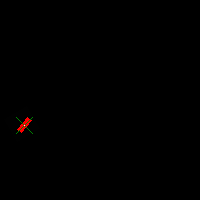

truth label: 


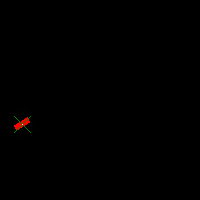

In [491]:
import torchvision 
import matplotlib.pyplot as plt
import copy
# get some random training images
with torch.no_grad():
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    outputs = model(images)
    
    # show images
    #imshow_coord(torchvision.utils.make_grid(images), (outputs))


    # print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  # for j in range(4)))
        
    loss = criterion(outputs.to(device), labels.to(device))
 
n =0 
#print(len(labels))
print('x,y truth', labels[n])
print('x,y guess by net', outputs[n])

images_copy = copy.deepcopy(images)
print('image size: ', images_copy[n].size())
print(loss)
print('net output: ')
imshow_coord(images_copy[n], outputs[n])
print('truth label: ')
imshow_coord(images_copy[n], labels[n])

#imagePIL = torchvision.transforms.ToPILImage()(images[n])
#print('PIL image size', imagePIL.size)
#imagePIL.save('test.png')
#display(imagePIL)

#display(Image.open('./data/rect'+str(n)+'.png'))

[ 57   9 105]
tensor([[ 56.7485,   9.4947, 104.5722]], device='cuda:0')


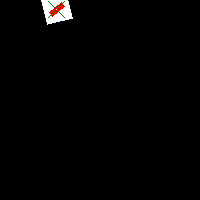

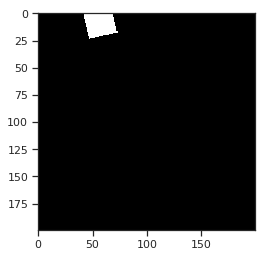

In [520]:
%matplotlib inline
#im = Image.open("Mew.jpg")
n = 12
n = np.random.rand()*len(images)
n = int(n)

image = io.imread('./data/rect'+str(n)+'.png')
image_tensor = torch.FloatTensor(image).permute(2, 0, 1) #PIL and torch expect difft orders
coords = torch.FloatTensor(true_coords[n])
with torch.no_grad():
    output = model(image_tensor)

print(true_coords[n])
print(output)
x,y,orient = output.cpu().numpy().flatten()
imshow_coord(image, (x,y, orient))
plt.imshow(image)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 3, 300, 400])
tensor(255.) tensor(0.) torch.Size([3, 304, 2012])
(304, 2012, 3)
3


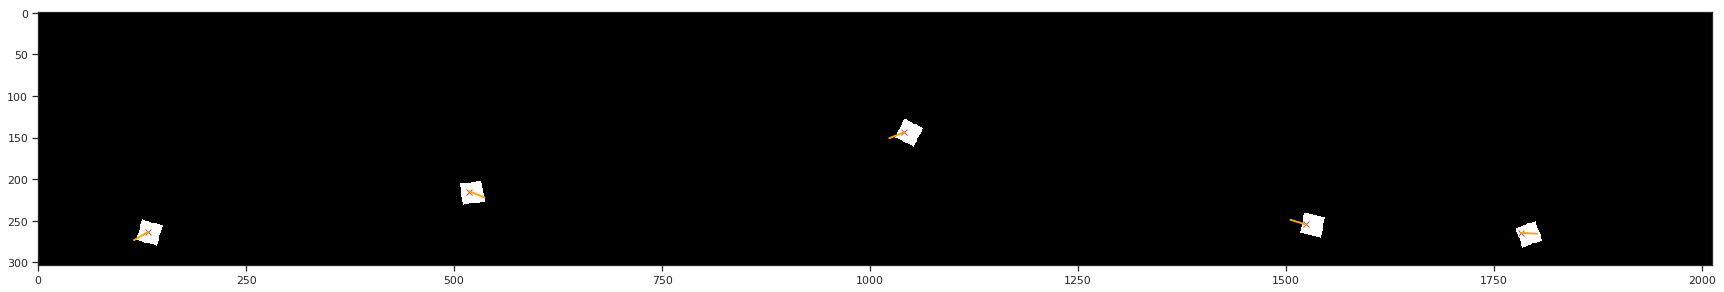

In [334]:
#img = Image.new('RGB', (300,400), 'gray')
sns.set_style("ticks")
n = 0
#imshow_coord(images[n], outputs[n], labels[n])

print(images.size())
a = torchvision.utils.make_grid(images)
print(a.max(), a.min(), a.size())
#a = a / 2 + 0.5     # unnormalize

a = a.cpu().numpy()
a = np.transpose(a,(1,2,0))
print(a.shape)
print(a.ndim)

#ran = a.max() - a.min()
#a = (a/ran )

fig,ax = plt.subplots(1)
# Display the image
ax.imshow(a)
#x,y = labels[0].numpy()
#plt.scatter(x,y, color='g', marker='x', linewidth='1')
labels = labels.cpu()

plt.rcParams['figure.figsize'] = [30,5]
import matplotlib.patches as patches
for i in range(len(labels)):
    x,y, orient = labels[i].numpy()

# class matplotlib.patches.Rectangle(xy, width, height, angle=0.0, **kwargs)[source]

    rect = patches.Rectangle((x + i*IMG_X, y), 1,20,angle=orient, fill=True, color='orange')
    ax.add_patch(rect)
    ax.scatter(x + i*IMG_X, y, color='r', marker='x', linewidth='1')
#plt.imshow(np.transpose(a, (2,0,1)))

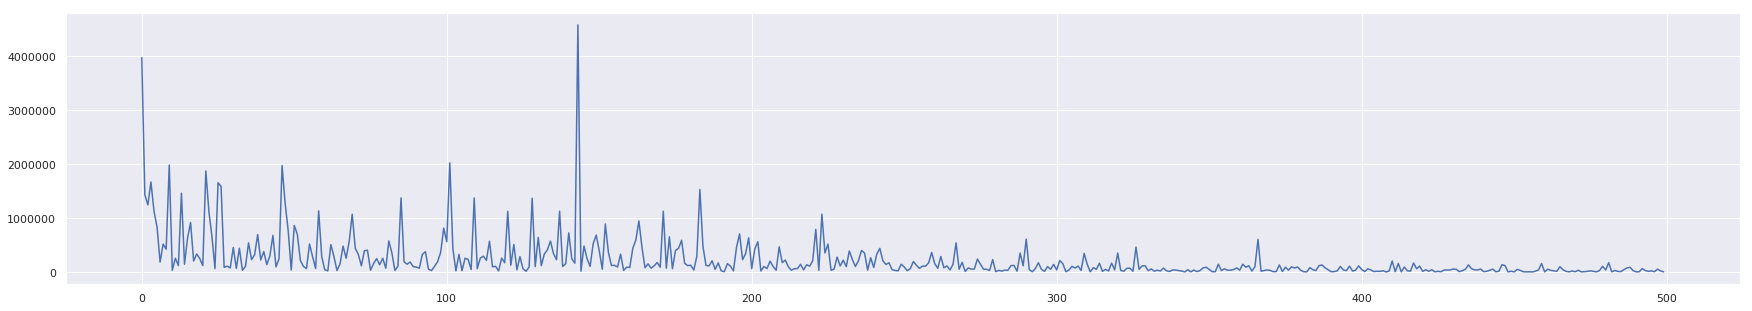

In [290]:
import seaborn as sns
sns.set()
f = plt.subplot()
f.plot(range(len(losses_list)), losses_list)

plt.rcParams['figure.figsize'] = [30, 5]
xposition = np.array(range(num_epoch))  * (total_step)
#print(xposition)
for xc in xposition:
    #plt.axvline(x=xc, color='k', linestyle='--')
    pass
    


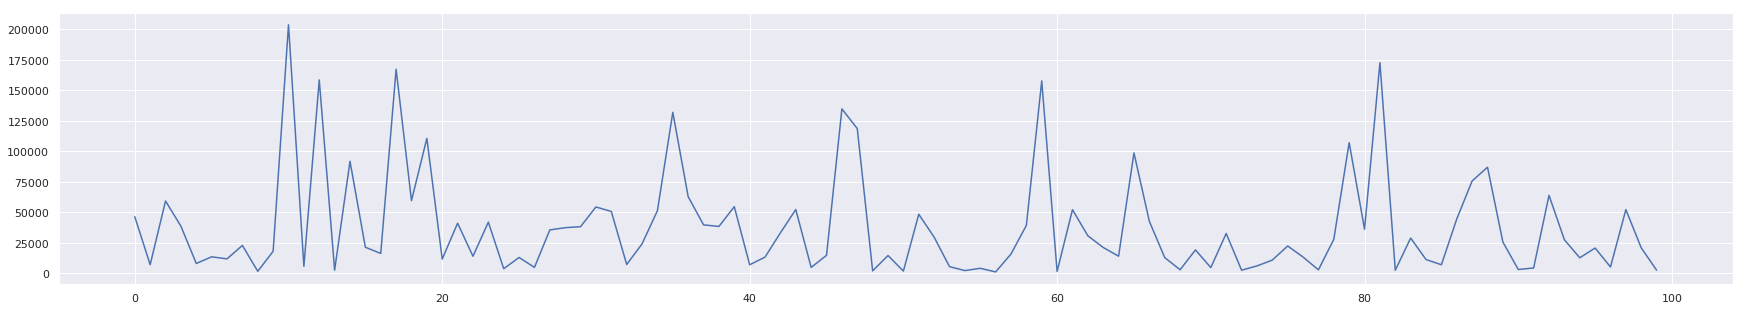

In [291]:
g = plt.subplot()
trunc = 100
g.plot(range(trunc), losses_list[-trunc:])

plt.show()

In [210]:
num_epochs = [10,20,50,70,100,150] 
num_classes = 3 # predicting x,y,orientation
batch_size = 5 
learning_rates = [0.001, 0.005, 0.01, 0.1]

meta_losses_list = []
for i in range(len(num_epochs)):
    num_epoch = num_epochs[i]
    learning_rate = learning_rates[0]
    losses_list = []
    print('Training model now... with: %d num_epoch and %d learning rate' % (num_epoch, learning_rate))
    
    total_step = len(train_loader)
    for epoch in range(num_epoch):
        for i_batch, (images, labels) in enumerate(train_loader):

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            # magnify orientation loss
            outputs[2] *= 10
            labels[2] *= 10
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            if (i_batch+1) % 1 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1,
                                                                          num_epochs,
                                                                          i_batch+1,
                                                                          total_step,
                                                                          loss.item()))
                losses_list.append(loss.item())
    meta_losses_list.append(losses_list)

Training model now... with: 10 num_epoch and 0 learning rate
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 98607.2812
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 31151.5293
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 83532.7344
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 16635.8398
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 19696.2480
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 35075.8047
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 10711.4795
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 132518.9844
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 247894.9688
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 19570.3711
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 10725.5186
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 71476.9062
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 147091.1406
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [4/10], 

Epoch [2/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 21684.4785
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 79751.4219
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 10548.6973
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 34173.8633
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 59032.1992
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 4336.9819
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 11125.2207
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 2800.4380
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 30270.2910
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 13145.3164
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 10741.6768
Epoch [4/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 96201.0156
Epoch [4/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 29998.5879
Epoch [4/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 91354.0469
Epoch [4/[10, 20, 50, 70, 100, 150]], Step [4/10

Epoch [16/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 2130.8337
Epoch [16/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 1678.9471
Epoch [16/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 9689.7295
Epoch [16/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 3651.5479
Epoch [16/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 5412.6802
Epoch [16/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 1963.3175
Epoch [16/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 1054.7240
Epoch [16/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 3871.5056
Epoch [16/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 2162.3042
Epoch [17/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 14169.8252
Epoch [17/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 24114.0605
Epoch [17/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 6731.2661
Epoch [17/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 7049.3062
Epoch [17/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 1831.4363
Epoch [17/[10, 20, 50, 70, 100, 150]], Step [

Epoch [9/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 4722.0649
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 1249.4465
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 1859.6952
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 1914.5073
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 12398.4492
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 11234.1875
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 6932.6465
Epoch [10/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 11675.1416
Epoch [10/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 8529.5879
Epoch [10/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 6974.4175
Epoch [10/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 6905.1611
Epoch [10/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 13838.4932
Epoch [10/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 16218.3838
Epoch [10/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 9098.3135
Epoch [10/[10, 20, 50, 70, 100, 150]], Step [8/10

Epoch [22/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 1323.3043
Epoch [22/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 1412.3196
Epoch [22/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 1095.1503
Epoch [22/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 645.3284
Epoch [22/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 2457.8962
Epoch [23/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 5033.0825
Epoch [23/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 1645.6644
Epoch [23/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 2154.2473
Epoch [23/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 237.2095
Epoch [23/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 5402.9712
Epoch [23/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 735.9441
Epoch [23/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 3672.7866
Epoch [23/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 2024.5414
Epoch [23/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 408.2853
Epoch [23/[10, 20, 50, 70, 100, 150]], Step [10/10]

Epoch [35/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 2724.5322
Epoch [35/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 538.5453
Epoch [35/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 8169.1826
Epoch [36/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 10120.7637
Epoch [36/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 546.1494
Epoch [36/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 9026.5830
Epoch [36/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 398.6853
Epoch [36/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 6227.3979
Epoch [36/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 2336.1118
Epoch [36/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 4014.7703
Epoch [36/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 382.1759
Epoch [36/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 678.6883
Epoch [36/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 3095.7771
Epoch [37/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 2073.9675
Epoch [37/[10, 20, 50, 70, 100, 150]], Step [2/10]

Epoch [48/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 1469.0337
Epoch [49/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 1662.0271
Epoch [49/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 2086.9441
Epoch [49/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 2537.7039
Epoch [49/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 2245.7314
Epoch [49/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 1278.5411
Epoch [49/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 894.7704
Epoch [49/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 9176.4805
Epoch [49/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 2388.9333
Epoch [49/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 8785.8789
Epoch [49/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 1794.1819
Epoch [50/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 5469.1455
Epoch [50/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 3792.3811
Epoch [50/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 1044.8121
Epoch [50/[10, 20, 50, 70, 100, 150]], Step [4/

Epoch [12/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 3660.2383
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 5407.4746
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 7612.8330
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 14038.7637
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 32009.4707
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 36696.9414
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 1939.0786
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 11008.8379
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 23074.0742
Epoch [13/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 82781.4688
Epoch [13/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 16776.9707
Epoch [13/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 11787.8418
Epoch [13/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 36877.2070
Epoch [13/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 22413.7871
Epoch [13/[10, 20, 50, 70, 100, 150]]

Epoch [24/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 1512.1208
Epoch [24/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 1269.9203
Epoch [24/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 8902.0430
Epoch [24/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 962.0701
Epoch [24/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 4391.5781
Epoch [24/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 2218.9268
Epoch [24/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 18910.4766
Epoch [24/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 4157.5962
Epoch [24/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 66842.9609
Epoch [25/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 4685.7544
Epoch [25/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 6615.3325
Epoch [25/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 8559.9854
Epoch [25/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 2569.1890
Epoch [25/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 3359.7271
Epoch [25/[10, 20, 50, 70, 100, 150]], Step [6

Epoch [36/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 35812.1992
Epoch [36/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 79096.6719
Epoch [36/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 31688.3145
Epoch [36/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 32372.2090
Epoch [36/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 16589.2012
Epoch [36/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 92523.1953
Epoch [36/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 6290.0996
Epoch [36/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 8961.5322
Epoch [36/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 13578.7314
Epoch [37/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 64890.2148
Epoch [37/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 72627.7969
Epoch [37/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 68973.1172
Epoch [37/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 35801.8086
Epoch [37/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 3851.0452
Epoch [37/[10, 20, 50, 70, 100, 150]

Epoch [48/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 2035.3685
Epoch [48/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 9279.6377
Epoch [48/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 68071.9375
Epoch [48/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 87507.2031
Epoch [48/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 8350.3438
Epoch [48/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 50076.3320
Epoch [48/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 11564.6143
Epoch [48/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 77695.8438
Epoch [48/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 84947.1172
Epoch [49/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 18652.5742
Epoch [49/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 62559.6484
Epoch [49/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 4289.5601
Epoch [49/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 34972.1211
Epoch [49/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 19679.4355
Epoch [49/[10, 20, 50, 70, 100, 150]]

Epoch [60/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 20603.3672
Epoch [60/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 14434.3438
Epoch [60/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 8852.8350
Epoch [60/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 4530.1353
Epoch [60/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 32827.7852
Epoch [60/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 18631.9414
Epoch [60/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 10176.3184
Epoch [60/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 5594.6802
Epoch [60/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 8718.6631
Epoch [61/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 38431.9570
Epoch [61/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 8368.4746
Epoch [61/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 20152.8027
Epoch [61/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 6295.6274
Epoch [61/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 7601.2207
Epoch [61/[10, 20, 50, 70, 100, 150]], S

Epoch [2/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 10748.7666
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 13991.4531
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 20286.5859
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 22584.0000
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 24475.7773
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 3174.8621
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 11010.4385
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 1999.4509
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 4127.0591
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 2369.4329
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 28876.4473
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 33627.8203
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 2699.1006
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 11483.0898
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [6/10], L

Epoch [15/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 6374.3594
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 16655.4922
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 8602.1064
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 7942.2188
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 603.5800
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 19005.7891
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 2958.0781
Epoch [16/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 5671.8379
Epoch [16/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 3388.6448
Epoch [16/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 2719.7126
Epoch [16/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 8688.0635
Epoch [16/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 2199.0903
Epoch [16/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 28869.3457
Epoch [16/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 10922.2334
Epoch [16/[10, 20, 50, 70, 100, 150]], Step 

Epoch [28/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 3085.9539
Epoch [28/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 2097.3948
Epoch [28/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 1638.4271
Epoch [28/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 305.8079
Epoch [28/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 1028.2850
Epoch [29/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 1524.8776
Epoch [29/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 367.3886
Epoch [29/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 2238.6997
Epoch [29/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 2981.6353
Epoch [29/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 682.8755
Epoch [29/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 6201.1631
Epoch [29/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 2255.3569
Epoch [29/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 1292.5922
Epoch [29/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 5730.5625
Epoch [29/[10, 20, 50, 70, 100, 150]], Step [10/10

Epoch [40/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 46890.8203
Epoch [40/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 135937.1094
Epoch [40/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 10692.8379
Epoch [40/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 146893.5938
Epoch [40/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 75729.8984
Epoch [41/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 97592.1172
Epoch [41/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 4273.3276
Epoch [41/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 44120.2578
Epoch [41/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 28790.1289
Epoch [41/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 102603.6016
Epoch [41/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 88916.8672
Epoch [41/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 64413.2031
Epoch [41/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 158418.7188
Epoch [41/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 5815.1167
Epoch [41/[10, 20, 50, 70, 100,

Epoch [52/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 13366.1367
Epoch [52/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 23788.9082
Epoch [52/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 7979.9341
Epoch [52/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 22240.8027
Epoch [52/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 115759.3516
Epoch [53/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 62407.6016
Epoch [53/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 31512.1309
Epoch [53/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 43690.5742
Epoch [53/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 3176.1272
Epoch [53/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 25118.6855
Epoch [53/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 11005.9248
Epoch [53/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 52950.5352
Epoch [53/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 11887.7959
Epoch [53/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 17528.0293
Epoch [53/[10, 20, 50, 70, 100, 15

Epoch [64/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 11838.2695
Epoch [64/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 3950.4229
Epoch [64/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 3637.9421
Epoch [64/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 21175.8320
Epoch [64/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 2525.5415
Epoch [65/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 30225.3516
Epoch [65/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 11617.5039
Epoch [65/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 62421.4883
Epoch [65/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 9768.9883
Epoch [65/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 10335.6045
Epoch [65/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 14122.4941
Epoch [65/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 10213.1338
Epoch [65/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 18197.6758
Epoch [65/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 32530.5000
Epoch [65/[10, 20, 50, 70, 100, 150]]

Epoch [76/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 2003.3870
Epoch [76/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 9998.4111
Epoch [76/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 56238.3867
Epoch [76/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 6913.9009
Epoch [77/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 14449.3105
Epoch [77/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 69638.1953
Epoch [77/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 15055.6855
Epoch [77/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 5607.3047
Epoch [77/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 6511.9248
Epoch [77/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 22437.8711
Epoch [77/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 11537.0176
Epoch [77/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 15241.6338
Epoch [77/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 4932.5918
Epoch [77/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 4704.4155
Epoch [78/[10, 20, 50, 70, 100, 150]], 

Epoch [88/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 1704.9965
Epoch [88/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 6377.2075
Epoch [88/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 24747.0723
Epoch [88/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 12896.9375
Epoch [89/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 1650.6823
Epoch [89/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 4354.5034
Epoch [89/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 3300.7178
Epoch [89/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 2370.3892
Epoch [89/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 1699.7162
Epoch [89/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 3002.6128
Epoch [89/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 5859.3521
Epoch [89/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 16217.4932
Epoch [89/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 8349.6650
Epoch [89/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 7411.0356
Epoch [90/[10, 20, 50, 70, 100, 150]], Step

Epoch [1/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 5945.4497
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 4264.5039
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 4627.0801
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 5239.8687
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 13929.4961
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 12298.2754
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 4258.8447
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 1529.1133
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 4090.2625
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 697.1913
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 16618.6504
Epoch [2/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 4202.4951
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 8794.2002
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 3808.0659
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 1

Epoch [14/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 1088.7599
Epoch [14/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 272.4341
Epoch [14/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 1971.6682
Epoch [14/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 475.6297
Epoch [14/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 10370.3623
Epoch [14/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 2513.7693
Epoch [14/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 284.8803
Epoch [14/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 4754.6064
Epoch [14/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 10786.2461
Epoch [14/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 1509.3217
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 381.2466
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 550.0633
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 696.0934
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 11460.2285
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [5/10]

Epoch [27/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 8639.6729
Epoch [27/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 892.9756
Epoch [27/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 2601.2344
Epoch [27/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 24843.6113
Epoch [27/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 10685.3535
Epoch [27/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 2975.7527
Epoch [27/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 5764.8623
Epoch [27/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 1945.6249
Epoch [28/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 7918.0791
Epoch [28/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 580.6488
Epoch [28/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 3809.8079
Epoch [28/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 3638.3401
Epoch [28/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 3281.9751
Epoch [28/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 4467.7998
Epoch [28/[10, 20, 50, 70, 100, 150]], Step [7/

Epoch [39/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 15716.4111
Epoch [39/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 2822.6489
Epoch [39/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 9567.2783
Epoch [39/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 22694.6230
Epoch [39/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 13188.0352
Epoch [39/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 52902.8828
Epoch [39/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 3745.0730
Epoch [39/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 7151.7090
Epoch [40/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 52851.4766
Epoch [40/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 4015.7131
Epoch [40/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 3765.1025
Epoch [40/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 23230.3574
Epoch [40/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 65655.0234
Epoch [40/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 18437.3164
Epoch [40/[10, 20, 50, 70, 100, 150]], 

Epoch [51/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 74561.0547
Epoch [51/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 23713.7871
Epoch [51/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 16630.0176
Epoch [51/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 16150.5850
Epoch [51/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 76462.9531
Epoch [51/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 9684.8857
Epoch [51/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 33930.5742
Epoch [51/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 49596.7422
Epoch [52/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 9438.3623
Epoch [52/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 55001.7578
Epoch [52/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 171959.0469
Epoch [52/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 18423.4453
Epoch [52/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 34239.6367
Epoch [52/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 159392.8281
Epoch [52/[10, 20, 50, 70, 100, 1

Epoch [63/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 116051.0234
Epoch [63/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 107042.6484
Epoch [63/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 84798.1641
Epoch [63/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 36910.6328
Epoch [63/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 61721.9883
Epoch [63/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 80749.8906
Epoch [63/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 6987.8896
Epoch [63/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 15933.6592
Epoch [64/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 16845.4277
Epoch [64/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 177958.5312
Epoch [64/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 82801.4062
Epoch [64/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 54042.4258
Epoch [64/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 68920.4531
Epoch [64/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 115219.7031
Epoch [64/[10, 20, 50, 70, 100

Epoch [75/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 12002.3604
Epoch [75/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 15922.5908
Epoch [75/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 5905.3188
Epoch [75/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 1777.1415
Epoch [75/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 44105.6250
Epoch [75/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 21140.5137
Epoch [75/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 14548.7217
Epoch [75/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 10496.1123
Epoch [76/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 39196.7422
Epoch [76/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 3584.4385
Epoch [76/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 2390.1375
Epoch [76/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 41753.0586
Epoch [76/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 9768.5332
Epoch [76/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 5653.7607
Epoch [76/[10, 20, 50, 70, 100, 150]], 

Epoch [87/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 2945.9595
Epoch [87/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 1950.6073
Epoch [87/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 1203.3036
Epoch [87/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 5153.5630
Epoch [87/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 33456.0352
Epoch [87/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 5335.5786
Epoch [87/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 1905.1576
Epoch [87/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 954.2343
Epoch [88/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 2041.7306
Epoch [88/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 877.0652
Epoch [88/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 2450.8472
Epoch [88/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 2450.6411
Epoch [88/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 4897.7280
Epoch [88/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 18060.1582
Epoch [88/[10, 20, 50, 70, 100, 150]], Step [7/

Epoch [100/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 7217.1216
Epoch [100/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 736.7946
Epoch [100/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 1890.4325
Epoch [100/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 869.1068
Epoch [100/[10, 20, 50, 70, 100, 150]], Step [9/10], Loss: 2424.2507
Epoch [100/[10, 20, 50, 70, 100, 150]], Step [10/10], Loss: 9464.3496
Epoch [101/[10, 20, 50, 70, 100, 150]], Step [1/10], Loss: 3137.3203
Epoch [101/[10, 20, 50, 70, 100, 150]], Step [2/10], Loss: 2999.5999
Epoch [101/[10, 20, 50, 70, 100, 150]], Step [3/10], Loss: 543.8420
Epoch [101/[10, 20, 50, 70, 100, 150]], Step [4/10], Loss: 8212.0986
Epoch [101/[10, 20, 50, 70, 100, 150]], Step [5/10], Loss: 3035.0312
Epoch [101/[10, 20, 50, 70, 100, 150]], Step [6/10], Loss: 3026.4622
Epoch [101/[10, 20, 50, 70, 100, 150]], Step [7/10], Loss: 6440.7939
Epoch [101/[10, 20, 50, 70, 100, 150]], Step [8/10], Loss: 3220.5217
Epoch [101/[10, 20, 50, 70, 100, 150

KeyboardInterrupt: 

In [ ]:
fig = plt.subplots()
trunc = 100
for l in meta_losses_list:
    plt.plot(range(len(l[-trunc:])), l[-trunc:])
plt.legend()
plt.show()